# 十分钟强化学习第五讲：SARSA和Q-Learning

![Alt text](frozen_lake.gif)

- G值(return)是一串行动轨迹上的回报(reward)之和。不同时点的G值存在递归关系

G(1:t) = R1 + R2 + R3 + ... + Rt

V(0) = E(G(1:t))

G(1:t) = R1 + G(2:t)

V(1) = E(G(2:t))

- 可以用自举(boostrap)的方式来估计价值函数，无需等待本轮游戏完结。 

target: G(1:t)

target: R1 + G(2:t)

target: R1 + V(1)

V(St) = V(St) + alpha * (Rt + V(St+1) -V(St))

In [82]:
from help import FrozenLake, print_policy, test_game
import numpy as np

In [83]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [84]:
alphas = decay_schedule(0.1,0.001,0.5,1000)

In [134]:
alphas = decay_schedule(1,0.0001,0.8, 20000)

In [85]:
import matplotlib.pylab as plt
%matplotlib inline

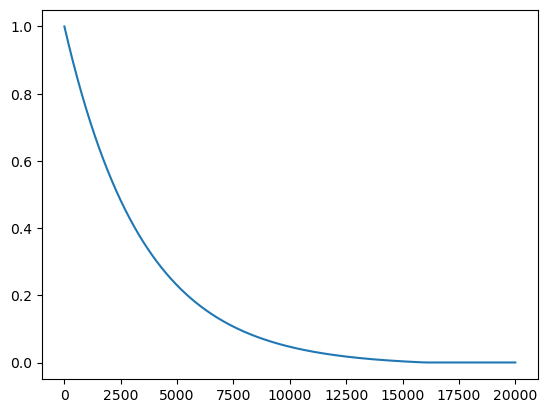

In [135]:
plt.plot(alphas)

In [87]:
def select_action(state, Q, epsilon):
    if np.random.random() > epsilon:
        return np.argmax(Q[state])
    else:
        return np.random.randint(len(Q[state]))

In [140]:
def sarsa(env,episodes=100, gamma=0.9,test_policy_freq=1000):
    nS, nA = 16, 4
    Q = np.zeros((nS, nA), dtype=np.float64)
    alphas = decay_schedule(0.5,0.01,0.5, episodes)
    epsilons = decay_schedule(1,0.01,0.8, episodes)
    
    for i in range(episodes): 
        state = env.reset()
        finished = False
        action = select_action(state, Q, epsilons[i])
        while not finished:
            next_state, reward, finished = env.step(action)
            next_action = select_action(next_state, Q, epsilons[i])
            target = reward + gamma * Q[next_state][next_action] * (not finished)
            error = target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[i] * error
            state, action = next_state, next_action

        pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        
        if i % test_policy_freq == 0:
                print("Test episode {} Reaches goal {:.2f}%. ".format
                (i, test_game(env, pi,)*100))

    return pi,Q

In [91]:
env = FrozenLake()

In [141]:
policy_sarsa,Q_sarsa = sarsa(env,episodes=20000)

Test episode 0 Reaches goal 0.00%. 
Test episode 1000 Reaches goal 27.00%. 
Test episode 2000 Reaches goal 21.00%. 
Test episode 3000 Reaches goal 15.00%. 
Test episode 4000 Reaches goal 17.00%. 
Test episode 5000 Reaches goal 14.00%. 
Test episode 6000 Reaches goal 68.00%. 
Test episode 7000 Reaches goal 78.00%. 
Test episode 8000 Reaches goal 41.00%. 
Test episode 9000 Reaches goal 63.00%. 
Test episode 10000 Reaches goal 61.00%. 
Test episode 11000 Reaches goal 61.00%. 
Test episode 12000 Reaches goal 74.00%. 
Test episode 13000 Reaches goal 50.00%. 
Test episode 14000 Reaches goal 67.00%. 
Test episode 15000 Reaches goal 72.00%. 
Test episode 16000 Reaches goal 65.00%. 
Test episode 17000 Reaches goal 72.00%. 
Test episode 18000 Reaches goal 75.00%. 
Test episode 19000 Reaches goal 68.00%. 


sarsa所利用的信息中噪声较少，学习比蒙特卡罗更快

In [142]:
print_policy(policy_sarsa)

Policy:
| 00      < | 01      ^ | 02      < | 03      ^ |
| 04      < |           | 06      > |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |


In [143]:
def q_learning(env,episodes=100,gamma=0.9,test_policy_freq=1000):
    nS, nA = 16,4
    Q = np.zeros((nS, nA), dtype=np.float64)
    alphas = decay_schedule(0.5,0.01,0.5, episodes)
    epsilons = decay_schedule(1,0.01,0.8, episodes)
    for i in range(episodes): 
        state = env.reset()
        finished = False
        while not finished:
            action = select_action(state, Q, epsilons[i])
            next_state, reward, finished = env.step(action)
            # 学习所用的Q值和sarsa不一样
            target = reward + gamma * Q[next_state].max() * (not finished)
            error = target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[i] * error
            state = next_state


        pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        
        if i % test_policy_freq == 0:
                print("Test episode {} Reaches goal {:.2f}%. ".format
                (i, test_game(env, pi)*100))

    return pi,Q

In [ ]:
policy_qlearning,Q_qlearning = q_learning(env,episodes=20000)

Test episode 0 Reaches goal 0.00%. 
Test episode 1000 Reaches goal 24.00%. 
Test episode 2000 Reaches goal 20.00%. 
Test episode 3000 Reaches goal 14.00%. 
Test episode 4000 Reaches goal 36.00%. 
Test episode 5000 Reaches goal 46.00%. 
Test episode 6000 Reaches goal 26.00%. 
Test episode 7000 Reaches goal 67.00%. 
Test episode 8000 Reaches goal 55.00%. 
Test episode 9000 Reaches goal 71.00%. 
Test episode 10000 Reaches goal 74.00%. 
Test episode 11000 Reaches goal 64.00%. 
Test episode 12000 Reaches goal 73.00%. 
Test episode 13000 Reaches goal 69.00%. 
Test episode 14000 Reaches goal 75.00%. 
Test episode 15000 Reaches goal 72.00%. 
Test episode 16000 Reaches goal 75.00%. 
Test episode 17000 Reaches goal 62.00%. 
Test episode 18000 Reaches goal 78.00%. 
Test episode 19000 Reaches goal 72.00%. 


- SARSA是“知行合一”的agent （on-policy）
- Q-learning是“知行不合一”的agent。(off-policy)
- 学习时使用下一状态的最大Q值做估计，更贪心一些

In [101]:
print_policy(policy_qlearning)

Policy:
| 00      < | 01      ^ | 02      < | 03      ^ |
| 04      < |           | 06      < |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |
